# Bank Marketing - term deposit prediction

Data Set Information:

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.

There are four datasets:
1) bank-additional-full.csv with all examples (41188) and 20 inputs, ordered by date (from May 2008 to November 2010), very close to the data analyzed in [Moro et al., 2014]
2) bank-additional.csv with 10% of the examples (4119), randomly selected from 1), and 20 inputs.
3) bank-full.csv with all examples and 17 inputs, ordered by date (older version of this dataset with less inputs).
4) bank.csv with 10% of the examples and 17 inputs, randomly selected from 3 (older version of this dataset with less inputs).
The smallest datasets are provided to test more computationally demanding machine learning algorithms (e.g., SVM).

The classification goal is to predict if the client will subscribe (yes/no) a term deposit (variable y).

Attribute Information:

Input variables:
### bank client data:
* 1 - age (numeric)
* 2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
* 3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
* 4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
* 5 - default: has credit in default? (categorical: 'no','yes','unknown')
* 6 - housing: has housing loan? (categorical: 'no','yes','unknown')
* 7 - loan: has personal loan? (categorical: 'no','yes','unknown')
* related with the last contact of the current campaign:
* 8 - contact: contact communication type (categorical: 'cellular','telephone')
* 9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
* 10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
* 11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after * the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
### other attributes:
* 12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
* 13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
* 14 - previous: number of contacts performed before this campaign and for this client (numeric)
* 15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
### social and economic context attributes
* 16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
* 17 - cons.price.idx: consumer price index - monthly indicator (numeric)
* 18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
* 19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
* 20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
* 21 - y - has the client subscribed a term deposit? (binary: 'yes','no')

Source:  http://archive.ics.uci.edu/ml/datasets/Bank+Marketing


## Loading libraries

In [1]:
# Load libraries
import numpy
import pandas as pd
from pandas import read_csv
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Classification Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.utils import resample

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Load dataset

In [2]:
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
import matplotlib.patches as patches
from aif360.algorithms.preprocessing import Reweighing
#from packages import *
#from ml_fairness import *
import matplotlib.pyplot as plt
import seaborn as sns



from IPython.display import Markdown, display

In [3]:
# Load dataset
dataset = pd.read_csv('../../Data/bank-additional-full.csv', sep = ';')

# dataset_all = read_csv(filename, delim_whitespace=False, header=0, sep=";")
#dataset = read_csv(filename, delim_whitespace=False, header=0, sep=";")

### drop column duration as suggested
> duration: last contact duration, in seconds (numeric). Important note:  this attribute highly affects the output target (e.g., if duration=0 then y="no"). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

In [27]:
# drop column duration as suggested
dataset = dataset.drop(columns=["duration"])

## View dataset

In [28]:
# shape
print("Shape:")
print(dataset.shape)
print()
print("Dataset info:")
print()
print(dataset.info())

Shape:
(41188, 20)

Dataset info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  campaign        41188 non-null  int64  
 11  pdays           41188 non-null  int64  
 12  previous        41188 non-null  int64  
 13  poutcome        41188 non-null  object 
 14  emp.var.rate    41188 non-null  float64
 15  cons.price.idx  41188 non-null  float64
 16  cons.conf.idx   41188 non-null  float64
 

### Look at class distribution

In [29]:
# class distribution
print(dataset.groupby("y").size())

y
no     36548
yes     4640
dtype: int64


The classes are imbalanced. The dataset needs to be resampled.

## Plotting some categorical variables

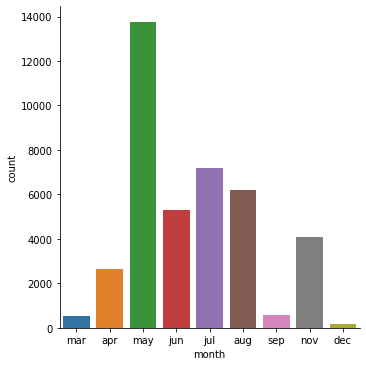

In [30]:
# show feature month - last contact month of year and count it
sns.catplot(x="month", kind="count", data=dataset,
            order=["mar", "apr", "may", "jun", "jul", "aug", "sep", "nov",
                   "dec"])
plt.show()

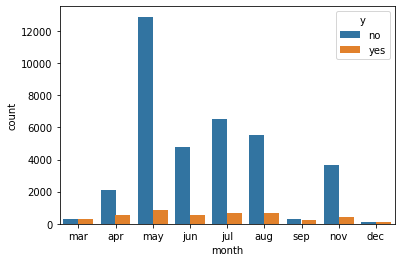

In [31]:
# count subscribed deposit per month
ax = sns.countplot(x="month", hue="y", data=dataset,
                   order=["mar", "apr", "may", "jun", "jul", "aug", "sep",
                          "nov", "dec"])

plt.show()

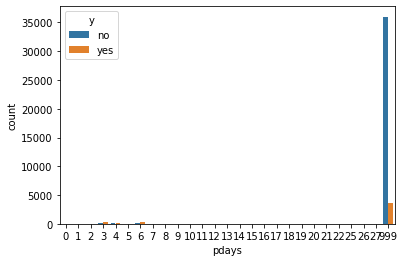

In [32]:
# pdays: number of days that passed by after the client was 
# last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
# count y
ax = sns.countplot(x="pdays", hue="y", data=dataset)
plt.show()

It seems to me that the variable "month" and "day_of_week" have no relevance for the prediction. For some reason, many calls were made in May.
Most calls were made for the first time (999).

## Prepare data

In [33]:
# Prepare Data
dataset_enc = dataset.copy()

# remove columns month and day_of_week
dataset_enc = dataset_enc.drop(columns=["month", "day_of_week"])

### Encode categorical variable

In [34]:
# use scikit-learn LabelEncoder to encode labels
lb = LabelEncoder()
# Convert categorical variable
dataset_enc = pd.get_dummies(dataset_enc, columns=['job'], prefix=['job'])
dataset_enc = pd.get_dummies(dataset_enc,
                             columns=['marital'], prefix=['marital'])
dataset_enc = pd.get_dummies(dataset_enc,
                             columns=['education'], prefix=['education'])
dataset_enc = pd.get_dummies(dataset_enc,
                             columns=['default'], prefix=['default'])
dataset_enc = pd.get_dummies(dataset_enc,
                             columns=['housing'], prefix=['housing'])
dataset_enc = pd.get_dummies(dataset_enc, columns=['loan'], prefix=['loan'])

# binary transform of column contact categorical: "cellular","telephone"
dataset_enc['contact'] = lb.fit_transform(dataset['contact'])
dataset_enc = pd.get_dummies(dataset_enc,
                             columns=['poutcome'], prefix=['poutcome'])

# move y at end of dataset
dataset_enc['y_class'] = dataset['y']

# remove original y column
dataset_enc = dataset_enc.drop(columns=["y"])

### View dataset again

In [35]:
dataset_enc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 47 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            41188 non-null  int64  
 1   contact                        41188 non-null  int32  
 2   campaign                       41188 non-null  int64  
 3   pdays                          41188 non-null  int64  
 4   previous                       41188 non-null  int64  
 5   emp.var.rate                   41188 non-null  float64
 6   cons.price.idx                 41188 non-null  float64
 7   cons.conf.idx                  41188 non-null  float64
 8   euribor3m                      41188 non-null  float64
 9   nr.employed                    41188 non-null  float64
 10  job_admin.                     41188 non-null  uint8  
 11  job_blue-collar                41188 non-null  uint8  
 12  job_entrepreneur               41188 non-null 

### Resample dataset - Down-sample Majority Class

In [36]:
# Resample
dataset_majority = dataset_enc[dataset_enc.y_class == "no"]
dataset_minority = dataset_enc[dataset_enc.y_class == "yes"]

# Downsample majority class
df_majority_downsampled = resample(dataset_majority, replace=False,
                                   n_samples=4640, random_state=123)

dataset_downsampled = pd.concat([df_majority_downsampled, dataset_minority])
dataset_downsampled.y_class.value_counts()

no     4640
yes    4640
Name: y_class, dtype: int64

**we now have a balanced dataset**

## Evaluate Algorithms

In [16]:
# Evaluate Algorithms
# Split-out validation dataset
array = dataset_downsampled.values
X = array[:, 0:46]
Y = array[:, 46]
validation_size = 0.20
seed = 7

X_train, X_validation, Y_train, Y_validation = \
    train_test_split(X, Y, test_size=validation_size, random_state=seed)

# Test options and evaluation metric
num_folds = 10
seed = 7
scoring = 'accuracy'

### Spot Check some Algorithms

LR 0.730872 0.010062
KNN 0.696392 0.011014
CART 0.648435 0.016886
NB 0.703802 0.015245


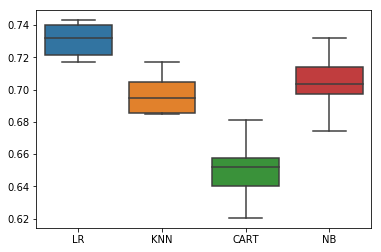

In [14]:
# Spot Check Algorithms
models = []
models.append(("LR", LogisticRegression()))
models.append(("KNN", KNeighborsClassifier()))
models.append(("CART", DecisionTreeClassifier()))
models.append(("NB", GaussianNB()))

# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold,
                                 scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = f"{name} {cv_results.mean():f} {cv_results.std():f}"
    print(msg)

# Compare Algorithms
sns.boxplot(x=names, y=results)
plt.show()

Logistic regression has the better result

### Spot Check some ensemble Algorithms

AB 0.738417 0.016105
GBM 0.745151 0.013374
RF 0.712279 0.013865
ET 0.693428 0.012231


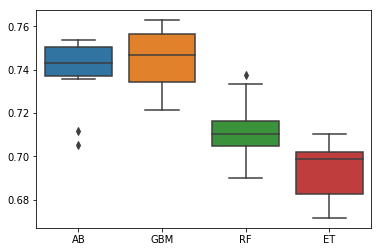

In [15]:
# Compare Algorithms

pipelines = []
pipelines.append(("AB",
                  Pipeline([("AB", AdaBoostClassifier())])))
pipelines.append(("GBM",
                  Pipeline([("GBM", GradientBoostingClassifier())])))
pipelines.append(("RF",
                  Pipeline([("RF", RandomForestClassifier())])))
pipelines.append(("ET",
                  Pipeline([("ET", ExtraTreesClassifier())])))

results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold,
                                 scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = f"{name} {cv_results.mean():f} {cv_results.std():f}"
    print(msg)

# Compare Algorithms
sns.boxplot(x=names, y=results)
plt.show()

GradientBoostingClassifier has the better result.

## Finalize Model

Accuracy score: 0.7505387931034483
Classification report
              precision    recall  f1-score   support

          no       0.71      0.86      0.78       939
         yes       0.82      0.64      0.72       917

   micro avg       0.75      0.75      0.75      1856
   macro avg       0.76      0.75      0.75      1856
weighted avg       0.76      0.75      0.75      1856

Confusion Matrix:
[[810 129]
 [334 583]]


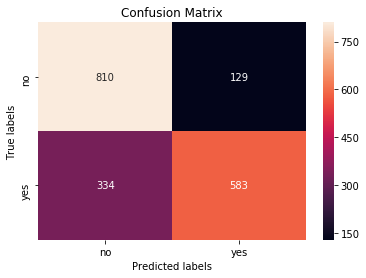

In [16]:
# Finalize Model
model = GradientBoostingClassifier()
# prepare the model
model.fit(X_train, Y_train)
predictions = model.predict(X_validation)

print("Accuracy score:", accuracy_score(Y_validation, predictions))
print("Classification report")
print(classification_report(Y_validation, predictions))

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(Y_validation, predictions))
conf_mat = confusion_matrix(Y_validation, predictions)
ax = plt.subplot()
sns.heatmap(conf_mat, annot=True, ax=ax, fmt='d')
# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['no', 'yes'])
ax.yaxis.set_ticklabels(['no', 'yes'])
plt.show()

## Fairness

In [4]:
# This DataFrame is created to stock differents models and fair metrics that we produce in this notebook
algo_metrics = pd.DataFrame(columns=['model', 'fair_metrics', 'prediction', 'probs'])

def add_to_df_algo_metrics(algo_metrics, model, fair_metrics, preds, probs, name):
    return algo_metrics.append(pd.DataFrame(data=[[model, fair_metrics, preds, probs]], columns=['model', 'fair_metrics', 'prediction', 'probs'], index=[name]))

In [5]:
def fair_metrics(dataset, pred, pred_is_dataset=False):
    if pred_is_dataset:
        dataset_pred = pred
    else:
        dataset_pred = dataset.copy()
        dataset_pred.labels = pred
    
    cols = ['statistical_parity_difference', 'equal_opportunity_difference', 'average_abs_odds_difference',  'disparate_impact', 'theil_index']
    obj_fairness = [[0,0,0,1,0]]
    
    fair_metrics = pd.DataFrame(data=obj_fairness, index=['objective'], columns=cols)
    
    for attr in dataset_pred.protected_attribute_names:
        idx = dataset_pred.protected_attribute_names.index(attr)
        privileged_groups =  [{attr:dataset_pred.privileged_protected_attributes[idx][0]}] 
        unprivileged_groups = [{attr:dataset_pred.unprivileged_protected_attributes[idx][0]}] 
        
        classified_metric = ClassificationMetric(dataset, 
                                                     dataset_pred,
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)

        metric_pred = BinaryLabelDatasetMetric(dataset_pred,
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)

        acc = classified_metric.accuracy()

        row = pd.DataFrame([[metric_pred.mean_difference(),
                                classified_metric.equal_opportunity_difference(),
                                classified_metric.average_abs_odds_difference(),
                                metric_pred.disparate_impact(),
                                classified_metric.theil_index()]],
                           columns  = cols,
                           index = [attr]
                          )
        fair_metrics = fair_metrics.append(row)    
    
    fair_metrics = fair_metrics.replace([-np.inf, np.inf], 2)
        
    return fair_metrics

def plot_fair_metrics(fair_metrics):
    fig, ax = plt.subplots(figsize=(20,4), ncols=5, nrows=1)

    plt.subplots_adjust(
        left    =  0.125, 
        bottom  =  0.1, 
        right   =  0.9, 
        top     =  0.9, 
        wspace  =  .5, 
        hspace  =  1.1
    )

    y_title_margin = 1.2

    plt.suptitle("Fairness metrics", y = 1.09, fontsize=20)
    sns.set(style="dark")

    cols = fair_metrics.columns.values
    obj = fair_metrics.loc['objective']
    size_rect = [0.2,0.2,0.2,0.4,0.25]
    rect = [-0.1,-0.1,-0.1,0.8,0]
    bottom = [-1,-1,-1,0,0]
    top = [1,1,1,2,1]
    bound = [[-0.1,0.1],[-0.1,0.1],[-0.1,0.1],[0.8,1.2],[0,0.25]]

    display(Markdown("### Check bias metrics :"))
    display(Markdown("A model can be considered bias if just one of these five metrics show that this model is biased."))
    for attr in fair_metrics.index[1:len(fair_metrics)].values:
        display(Markdown("#### For the %s attribute :"%attr))
        check = [bound[i][0] < fair_metrics.loc[attr][i] < bound[i][1] for i in range(0,5)]
        display(Markdown("With default thresholds, bias against unprivileged group detected in **%d** out of 5 metrics"%(5 - sum(check))))

    for i in range(0,5):
        plt.subplot(1, 5, i+1)
        ax = sns.barplot(x=fair_metrics.index[1:len(fair_metrics)], y=fair_metrics.iloc[1:len(fair_metrics)][cols[i]])
        
        for j in range(0,len(fair_metrics)-1):
            a, val = ax.patches[j], fair_metrics.iloc[j+1][cols[i]]
            marg = -0.2 if val < 0 else 0.1
            ax.text(a.get_x()+a.get_width()/5, a.get_y()+a.get_height()+marg, round(val, 3), fontsize=15,color='black')

        plt.ylim(bottom[i], top[i])
        plt.setp(ax.patches, linewidth=0)
        ax.add_patch(patches.Rectangle((-5,rect[i]), 10, size_rect[i], alpha=0.3, facecolor="green", linewidth=1, linestyle='solid'))
        plt.axhline(obj[i], color='black', alpha=0.3)
        plt.title(cols[i])
        ax.set_ylabel('')    
        ax.set_xlabel('')

In [6]:
def get_fair_metrics_and_plot(data, model, plot=False, model_aif=False):
    pred = model.predict(data).labels if model_aif else model.predict(data.features)
    # fair_metrics function available in the metrics.py file
    fair = fair_metrics(data, pred)

    if plot:
        # plot_fair_metrics function available in the visualisations.py file
        # The visualisation of this function is inspired by the dashboard on the demo of IBM aif360 
        plot_fair_metrics(fair)
        display(fair)
    
    return fair

In [40]:
#function to creat group of ages, this helps because we have 78 differente values here
def age(dataframe):
    dataframe.loc[dataframe['age'] < 25, 'age'] = 0
    dataframe.loc[dataframe['age'] >= 25, 'age'] = 1
    dataframe.loc[dataframe['y_class'] == 'no', 'y_class'] = 0
    dataframe.loc[dataframe['y_class'] == 'yes', 'y_class'] = 1
           
    return dataframe

age(dataset_enc);


dataset_enc

,age,contact,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,poutcome_failure,poutcome_nonexistent,poutcome_success,y_class
0,1,1,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,1,0,0,1,0,0,0,1,0,0
1,1,1,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,1,0,0,1,0,0,0,1,0,0
2,1,1,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,1,1,0,0,0,1,0,0
3,1,1,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,1,0,0,1,0,0,0,1,0,0
4,1,1,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,1,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,1,0,1,999,0,-1.1,94.767,-50.8,1.028,4963.6,...,0,0,1,1,0,0,0,1,0,1
41184,1,0,1,999,0,-1.1,94.767,-50.8,1.028,4963.6,...,1,0,0,1,0,0,0,1,0,0
41185,1,0,2,999,0,-1.1,94.767,-50.8,1.028,4963.6,...,0,0,1,1,0,0,0,1,0,0
41186,1,0,1,999,0,-1.1,94.767,-50.8,1.028,4963.6,...,1,0,0,1,0,0,0,1,0,1


In [41]:
#print(X)


#combine_final = [train_df, test_df]
#result = pd.concat(combine_final)
#print(result.ifany())
#print(result)
privileged_groups = [{'age': 1}]
unprivileged_groups = [{'age': 0}]
dataset_orig = StandardDataset(dataset_enc,
                                  label_name='y_class',
                                  protected_attribute_names=['age'],
                                  favorable_classes=[1],
                                  privileged_classes=[[1]])

#metric_orig_train = BinaryLabelDatasetMetric(dataset_orig, 
#                                             unprivileged_groups=unprivileged_groups,
#                                             privileged_groups=privileged_groups)
#display(Markdown("#### Original training dataset"))
#print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())


In [42]:
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.130428


In [7]:
data_orig_train = pd.read_pickle('../../Results/ExtraTrees/1-subscription-predictor_Train.pkl')
data_orig_test = pd.read_pickle('../../Results/ExtraTrees/1-subscription-predictor_Test.pkl')

X_train = data_orig_train.features
y_train = data_orig_train.labels.ravel()

X_test = data_orig_test.features
y_test = data_orig_test.labels.ravel()
num_estimators = 100


In [43]:
import ipynbname
nb_fname = ipynbname.name()
nb_path = ipynbname.path()

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import pickle
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier

data_orig_train, data_orig_test = dataset_orig.split([0.7], shuffle=True)
X_train = data_orig_train.features
y_train = data_orig_train.labels.ravel()

X_test = data_orig_test.features
y_test = data_orig_test.labels.ravel()

num_estimators = 100

model = ExtraTreesClassifier(n_estimators = 100)

mdl = model.fit(X_train, y_train)
with open('../../Results/ExtraTrees/' + nb_fname + '.pkl', 'wb') as f:
        pickle.dump(mdl, f)

with open('../../Results/ExtraTrees/' + nb_fname + '_Train' + '.pkl', 'wb') as f:
    pickle.dump(data_orig_train, f) 
    
with open('../../Results/ExtraTrees/' + nb_fname + '_Test' + '.pkl', 'wb') as f:
    pickle.dump(data_orig_test, f) 

In [45]:
from csv import writer
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

final_metrics = []
accuracy = []
f1= []

for i in range(1,num_estimators+1):

    model = ExtraTreesClassifier(n_estimators = i)
    
    mdl = model.fit(X_train, y_train)
    yy = mdl.predict(X_test)
    accuracy.append(accuracy_score(y_test, yy))
    f1.append(f1_score(y_test, yy))
    fair = get_fair_metrics_and_plot(data_orig_test, mdl)                           
    fair_list = fair.iloc[1].tolist()
    fair_list.insert(0, i)
    final_metrics.append(fair_list)


In [46]:
import numpy as np
final_result = pd.DataFrame(final_metrics)
print(final_result)
final_result[4] = np.log(final_result[4])
final_result = final_result.transpose()
final_result.loc[0] = f1  # add f1 and acc to df
acc = pd.DataFrame(accuracy).transpose()
acc = acc.rename(index={0: 'accuracy'})
final_result = pd.concat([acc,final_result])
final_result = final_result.rename(index={0: 'f1', 1: 'statistical_parity_difference', 2: 'equal_opportunity_difference', 3: 'average_abs_odds_difference', 4: 'disparate_impact', 5: 'theil_index'})
final_result.columns = ['T' + str(col) for col in final_result.columns]
final_result.insert(0, "classifier", final_result['T' + str(num_estimators - 1)])   ##Add final metrics add the beginning of the df
final_result.to_csv('../../Results/ExtraTrees/' + nb_fname + '.csv')
final_result

      0         1         2         3         4         5
0     1  0.087625  0.086041  0.068823  1.900510  0.102486
1     2  0.044555 -0.014821  0.025099  1.765748  0.104897
2     3  0.090861  0.114942  0.081111  2.084316  0.100298
3     4  0.064741  0.004508  0.027208  1.989991  0.100977
4     5  0.096302  0.073619  0.067905  2.130234  0.096998
..  ...       ...       ...       ...       ...       ...
95   96  0.097409  0.087594  0.074067  2.260991  0.096498
96   97  0.090752  0.046097  0.054428  2.127626  0.096007
97   98  0.092244  0.064128  0.061870  2.167812  0.095876
98   99  0.088488  0.067234  0.060830  2.115576  0.096417
99  100  0.089068  0.068787  0.061838  2.131164  0.096462

[100 rows x 6 columns]


,classifier,T0,T1,T2,T3,T4,T5,T6,T7,T8,...,T90,T91,T92,T93,T94,T95,T96,T97,T98,T99
accuracy,0.876993,0.858137,0.876750,0.868819,0.878126,0.872623,0.878045,0.871247,0.877559,0.873918,...,0.876831,0.876184,0.877721,0.876750,0.878773,0.877640,0.876669,0.877640,0.876750,0.876993
f1,0.354291,0.321332,0.270244,0.329334,0.309808,0.353859,0.334658,0.340108,0.336694,0.354063,...,0.355631,0.353885,0.361099,0.353291,0.366328,0.353293,0.358586,0.358779,0.354934,0.354291
statistical_parity_difference,0.089068,0.087625,0.044555,0.090861,0.064741,0.096302,0.082415,0.080836,0.098626,0.080753,...,0.074375,0.084400,0.081141,0.074955,0.088239,0.097409,0.090752,0.092244,0.088488,0.089068
equal_opportunity_difference,0.068787,0.086041,-0.014821,0.114942,0.004508,0.073619,0.051184,0.042818,0.078706,0.061023,...,0.050756,0.051532,0.029619,0.053861,0.056364,0.087594,0.046097,0.064128,0.067234,0.068787
average_abs_odds_difference,0.061838,0.068823,0.025099,0.081111,0.027208,0.067905,0.053135,0.048153,0.073191,0.053461,...,0.045785,0.052654,0.042208,0.047477,0.055905,0.074067,0.054428,0.061870,0.060830,0.061838
disparate_impact,0.756668,0.642122,0.568574,0.734441,0.688130,0.756232,0.765243,0.676788,0.857967,0.675796,...,0.658958,0.720383,0.701404,0.666261,0.746197,0.815803,0.755007,0.773718,0.749327,0.756668
theil_index,0.096462,0.102486,0.104897,0.100298,0.100977,0.096998,0.098473,0.098764,0.098326,0.096836,...,0.096328,0.096603,0.095600,0.096604,0.094881,0.096498,0.096007,0.095876,0.096417,0.096462


In [20]:
from csv import writer
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

final_metrics = []
accuracy = []
f1= []

for i in range(0,10):

    #model = RandomForestClassifier(n_estimators=100, bootstrap = True)
    model = ExtraTreesClassifier(n_estimators=100, bootstrap = False)

    
    mdl = model.fit(X_train, y_train)
    yy = mdl.predict(X_test)
    accuracy.append(accuracy_score(y_test, yy))
    f1.append(f1_score(y_test, yy))
    fair = get_fair_metrics_and_plot(data_orig_test, mdl)                           
    fair_list = fair.iloc[1].tolist()
    print(fair_list)
    #fair_list.insert(0, i)
    final_metrics.append(fair_list)


[0.06660162795438135, -0.013693259779899769, 0.017705818827188215, 1.7508520292903327, 0.08528560506085521]
[0.07417738553013892, 0.013343227576937067, 0.017725481505719842, 1.8362594453532757, 0.08456808361412213]
[0.08542700980849426, 0.012405141272997133, 0.02487065155171942, 1.9618489127475007, 0.08456353045814147]
[0.07978945768251433, 0.004046372266248488, 0.018802125249065178, 1.9184164479440067, 0.08510071124370147]
[0.07235319216564227, -0.006272577077091057, 0.016014405128405764, 1.799256736127013, 0.08454863761868665]
[0.07773724014745562, -0.03237097812998796, 0.03732674811953368, 1.874145299145299, 0.08500157889971698]
[0.07337930093317163, -0.019321777603539536, 0.025531326944316802, 1.8198851573055392, 0.08467907795843196]
[0.07312579678900509, -0.015485424659068658, 0.024326972665462285, 1.850645044610562, 0.08678334039331252]
[0.08807476774356264, 0.0188877376718658, 0.02804705682448276, 1.9790922533317972, 0.08339972784234143]
[0.0773952038916125, -0.00439640446921113

In [21]:
from __future__ import division
def mean(a):
    return sum(a) / len(a)

print(list(map(mean, zip(*final_metrics))))
final_metrics = list(map(mean, zip(*final_metrics)))
print(mean(accuracy))
print(mean(f1))

[0.07680609826459786, -0.004285794293074963, 0.022854901304638856, 1.8657365991670563, 0.0848412062366973]
0.8961925843940233
0.5202048432922777


In [22]:
import numpy as np
final_result = pd.DataFrame(final_metrics)
final_result[0][3] = np.log(final_result[0][3])
print(final_result)

          0
0  0.076806
1 -0.004286
2  0.022855
3  0.623656
4  0.084841
